<a href="https://colab.research.google.com/github/BMateusSs/Projeto-PISI3/blob/main/dbscan_unsupervised_model_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install dependencies as needed:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "winemag-data-130k-v2.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "zynicide/wine-reviews",
  file_path
)

/tmp/ipython-input-1-1525670069.py:9: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Limpeza dos dados

In [2]:
initial_lines_quantity = len(df['description'])
print(initial_lines_quantity)
df.head()
# Retirar linhas incompletas
df.dropna(axis="index", how= "any", subset=["price", "points", "region_1", "country", "variety", "designation"], inplace=True)
final_lines_quantity = len(df["description"])
print(final_lines_quantity)

129971
70175


In [ ]:
# Se for feito a limpeza das descrições para tirar stop words e pontuação
# sentence transformer já lida com o stop words e pontuação
import nltk
from nltk.corpus import stopwords
import string

# Baixe as stopwords se ainda não as tiver
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Converter para lowercase
    text = text.lower()
    # Remover pontuação
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remover stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Aplicar a função de limpeza na coluna 'description'
df['description'] = df['description'].apply(clean_text)
df.head()
# geimport os

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
3,3,US,pineapple rind lemon pith orange blossom start...,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,much like regular bottling 2012 comes across r...,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,5,Spain,blackberry raspberry aromas show typical navar...,Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,6,Italy,heres bright informal red opens aromas candied...,Belsito,87,16.0,Sicily & Sardinia,Vittoria,NaN,Kerin O’Keefe,@kerinokeefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,9,France,great depth flavor fresh apple pear fruits tou...,Les Natures,87,27.0,Alsace,Alsace,NaN,Roger Voss,@vossroger,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [ ]:
# Gerar embdeings, só precisa fazer isso uma vez
# NÃO FAÇA ISSO NOVAMENTE SE JÁ POSSUI OS EMBEDINGS
from sentence_transformers import SentenceTransformer

# Defina o número de threads para usar todas as CPUs
os.environ["OMP_NUM_THREADS"] = "16"
os.environ["TOKENIZERS_PARALLELISM"] = "true"

model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

# Ajuste o batch_size para melhor performance (ex: 128)
embeddings = model.encode(
    df['description'].tolist(),
    show_progress_bar=True,
    batch_size=128,
    device='cpu'  # Garante uso da CPU
)

KeyboardInterrupt: 

In [ ]:
# Funções de escrita e leitura de arquivos numpy
import numpy as np
def write_numpy_file(write_path, content):
    np.save(write_path, content)

def read_numpy_file(read_path):
    return np.load(read_path)

# Funções de escrita e leitura de arquivos CSV
import numpy as np
import pandas as pd

def write_embeddings_csv(write_path: str, embeddings_array: np.ndarray):
    """Salva um array numpy de embeddings em um arquivo CSV."""
    # Converter o array numpy para um DataFrame pandas para facilitar o salvamento em CSV
    df_embeddings = pd.DataFrame(embeddings_array)
    # Salvar o DataFrame em CSV. index=False para não salvar o índice do DataFrame como coluna.
    df_embeddings.to_csv(write_path, index=False)
    print(f"Embeddings salvos como CSV em: {write_path}")


def read_embeddings_csv(read_path: str) -> np.ndarray:
    """Lê embeddings de um arquivo CSV e retorna como um array numpy."""
    # Ler o arquivo CSV para um DataFrame pandas
    df_embeddings = pd.read_csv(read_path)
    # Converter o DataFrame de volta para um array numpy
    embeddings_array = df_embeddings.values
    print(f"Embeddings lidos de CSV: {read_path}")
    return embeddings_array


In [ ]:
# Escrever no disco os embeddings
write_numpy_file(write_path=embeddings_path, content=embeddings)

NameError: name 'embeddings_path' is not defined

In [ ]:
# Ler os embeddings que estão salvo no disco
embeddings_path = "embeddings_paraphrase_multilingual_mpnet_base_v2.npy"
embeddings = read_numpy_file(embeddings_path)
len(embeddings)

FileNotFoundError: [Errno 2] No such file or directory: 'embeddings_paraphrase_multilingual_mpnet_base_v2.npy'

In [ ]:
# funções para reduzir a dimensionalidade
def umap_fit_transform(embeddings, **kwargs):
    import umap
    reducer = umap.UMAP(**kwargs)
    umap_2d = reducer.fit_transform(embeddings)
    return umap_2d
def tsne_fit_transform(embeddings, **kwargs):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_2d = tsne.fit_transform(embeddings)
    return tsne_2d


In [ ]:
# Choose umap for generating 2d embedings
embeddings_2d = umap_fit_transform(embeddings, random_state=42)
len(embeddings_2d)


NameError: name 'embeddings' is not defined

In [ ]:
write_numpy_file("emdebddings_2d.npy", embeddings_2d)

NameError: name 'embeddings_2d' is not defined

In [3]:
#Ler emdebddings 2d
# Funções de escrita e leitura de arquivos CSV (mantenha essas funções definidas)
import numpy as np
import pandas as pd
import gdown
import os

# Mantenha a definição da função read_embeddings_csv
def read_embeddings_csv(read_path: str) -> np.ndarray:
    """Lê embeddings de um arquivo CSV e retorna como um array numpy."""
    # Ler o arquivo CSV para um DataFrame pandas
    df_embeddings = pd.read_csv(read_path)
    # Converter o DataFrame de volta para um array numpy
    embeddings_array = df_embeddings.values
    print(f"Embeddings lidos de CSV: {read_path}")
    return embeddings_array

# --- Agora, use o link do Google Drive para baixar e carregar ---

# Define o link do Google Drive para o arquivo CSV
# Gdown geralmente consegue lidar com o link 'sharing', mas o formato 'uc' é mais robusto para download direto.
# Vamos extrair o ID do link e usar o formato 'uc'.
drive_link = "https://drive.google.com/file/d/11-6rZ7TXr5Gato7iIkBHv8XYy5ScNqMx/view?usp=sharing"

# Extrair o ID do arquivo do link
# O ID está entre '/d/' e '/view'
drive_file_id = drive_link.split('/d/')[1].split('/view')[0]

# Construir o URL de download direto usando o ID
download_url = f"https://drive.google.com/uc?id={drive_file_id}"

# Define o caminho de saída onde o arquivo será salvo temporariamente no Colab
output_csv_path = "downloaded_embeddings_2d.csv"

print(f"Tentando baixar o arquivo do Google Drive ID: {drive_file_id}")

try:
    # Baixar o arquivo CSV usando gdown
    gdown.download(download_url, output_csv_path, quiet=False)
    print(f"Arquivo baixado com sucesso para {output_csv_path}")

    # Carregar o arquivo CSV baixado usando a função definida
    embeddings_2d = read_embeddings_csv(output_csv_path)

    print(f"Dados carregados na variável embeddings_2d. Forma: {embeddings_2d.shape}")

    # Opcional: remover o arquivo CSV baixado para liberar espaço
    # os.remove(output_csv_path)
    # print(f"Arquivo temporário {output_csv_path} removido.")

except Exception as e:
    print(f"Ocorreu um erro durante o download ou carregamento do CSV: {e}")
    print("Por favor, verifique se o link do Google Drive está correto e o arquivo é acessível (compartilhado).")

print(len(embeddings_2d))
# Agora a variável 'embeddings_2d' deve conter os dados carregados do CSV.
# Você pode continuar com as etapas de K-Means, etc., usando 'embeddings_2d'.

Tentando baixar o arquivo do Google Drive ID: 11-6rZ7TXr5Gato7iIkBHv8XYy5ScNqMx


Downloading...
From: https://drive.google.com/uc?id=11-6rZ7TXr5Gato7iIkBHv8XYy5ScNqMx
To: /content/downloaded_embeddings_2d.csv
100%|██████████| 1.43M/1.43M [00:00<00:00, 74.7MB/s]

Arquivo baixado com sucesso para downloaded_embeddings_2d.csv
Embeddings lidos de CSV: downloaded_embeddings_2d.csv
Dados carregados na variável embeddings_2d. Forma: (70175, 2)
70175


# Usando o DBSCAN para gerar os clusters

In [30]:
from sklearn.cluster import DBSCAN
import numpy as np

# Assuming embeddings_2d contains your 2D embedding data

# Define the DBSCAN parameters
# eps is the maximum distance between two samples for one to be considered as in the neighborhood of the other
# min_samples is the number of samples in a neighborhood for a point to be considered as a core point.
db = DBSCAN(eps=0.255, min_samples=40 )

# Fit the DBSCAN model to your data
clusters_dbscan = db.fit_predict(embeddings_2d)

# The clusters_dbscan array will contain the cluster labels for each data point.
# Noise points are assigned the label -1.

# You can add the cluster labels to your DataFrame
df['cluster'] = clusters_dbscan

# Print the number of unique clusters found (excluding noise)
n_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
n_noise = list(clusters_dbscan).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")


Estimated number of clusters: 16
Estimated number of noise points: 196


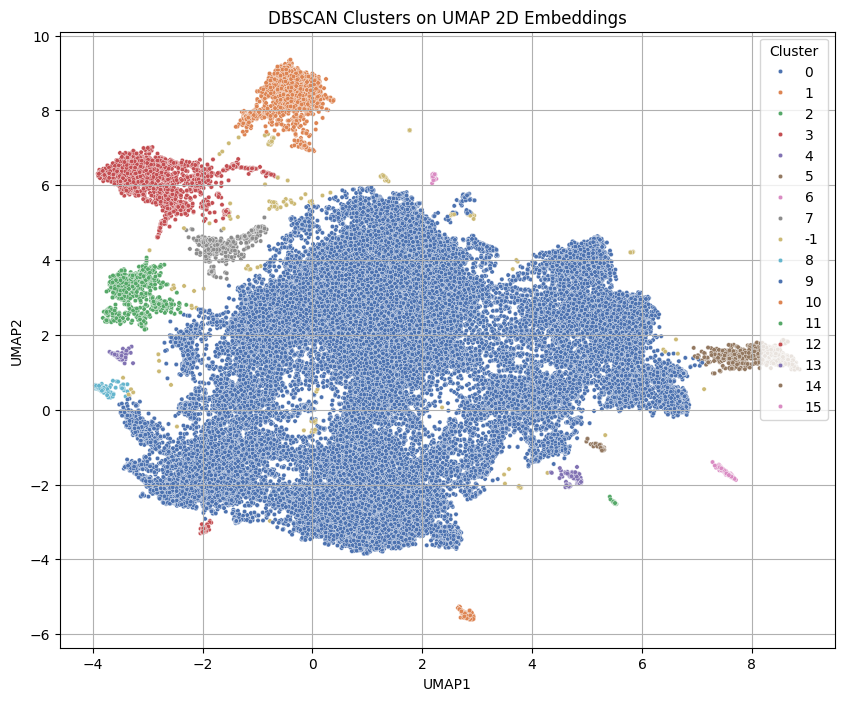

In [31]:
# Plot the DSCAN in a graph
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have the df DataFrame with the 'cluster_dbscan' column
# and the embeddings_2d array

# Create a new DataFrame for plotting
df_plot_dbscan = pd.DataFrame({
    'UMAP1': embeddings_2d[:, 0],
    'UMAP2': embeddings_2d[:, 1],
    'DBSCAN_Cluster': df['cluster'].astype(str) # Convert cluster labels to string for coloring
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_plot_dbscan,
    x='UMAP1',
    y='UMAP2',
    hue='DBSCAN_Cluster',
    palette='deep', # Or any other color palette
    s=10 # Adjust point size as needed
)
plt.title('DBSCAN Clusters on UMAP 2D Embeddings')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Analisando dados dos Clusters

In [71]:
100 * (len(df[df["cluster"]==0]) / len(df["description"]))

84.35055219095119

In [72]:
# Cria um novo DataFrame que inclui todas as linhas onde a coluna 'cluster' NÃO é igual a 0
df_sem_cluster_0 = df[df['cluster'] != 0].copy()

# Agora df_sem_cluster_0 contém todas as linhas, exceto aquelas que pertencem ao cluster 0.

# Para verificar, você pode imprimir o tamanho do novo DataFrame
print(f"Número de linhas no DataFrame original: {len(df)}")
print(f"Número de linhas no DataFrame sem o Cluster 0: {len(df_sem_cluster_0)}")
print("\nPrimeiras 5 linhas do DataFrame sem o Cluster 0:")
df_sem_cluster_0.head()

Número de linhas no DataFrame original: 70175
Número de linhas no DataFrame sem o Cluster 0: 10982

Primeiras 5 linhas do DataFrame sem o Cluster 0:


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,cluster
25,25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,1
53,53,France,"Fruity and lightly herbaceous, this has fine t...",La Fleur d'Amélie,85,15.0,Bordeaux,Bordeaux Blanc,NaN,Roger Voss,@vossroger,Château de Sours 2011 La Fleur d'Amélie (Bord...,Bordeaux-style White Blend,Château de Sours,2
63,63,France,"This fat, yeasty Champagne is comprised predom...",Brut Rosé,86,58.0,Champagne,Champagne,NaN,Roger Voss,@vossroger,Roland Champion NV Brut Rosé (Champagne),Champagne Blend,Roland Champion,1
69,69,France,"This cooperative, based in Aÿ, has benefited f...",Brut Rosé,86,55.0,Champagne,Champagne,NaN,Roger Voss,@vossroger,Collet NV Brut Rosé (Champagne),Champagne Blend,Collet,1
77,77,Australia,This medium-bodied Chardonnay features aromas ...,Made With Organic Grapes,86,18.0,South Australia,South Australia,NaN,Joe Czerwinski,@JoeCz,Yalumba 2016 Made With Organic Grapes Chardonn...,Chardonnay,Yalumba,3


In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_cluster_numerical_distribution_with_mpl_table(df: pd.DataFrame, numerical_col: str, y_limit: tuple = None, figsize: tuple = (12, 8)):
    """
    Generates a box plot showing the distribution of a numerical column
    across different clusters and plots the mean for each cluster.
    Also, displays a table with mean, median, and standard deviation
    by cluster within the plot using matplotlib.pyplot.table.

    Args:
        df (pd.DataFrame): The input DataFrame containing the numerical column
                           and a 'cluster' column.
        numerical_col (str): The name of the numerical column to plot (e.g., 'price', 'points').
        y_limit (tuple, optional): A tuple (min, max) to set the limits of the y-axis
                                   for zooming. Defaults to None (no zoom).
        figsize (tuple, optional): The size of the matplotlib figure. Defaults to (12, 8).
    """
    # Configure plot style
    sns.set_theme(style="whitegrid")

    # Create the figure and axes for the Box Plot and the table
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [3, 1]}) # 2 rows, 1 column, adjust height ratio

    # Generate the Box Plot on the first axis (ax1)
    sns.boxplot(x='cluster', y=numerical_col, data=df, palette="viridis", ax=ax1)

    # Calculate the mean of the numerical column by cluster
    mean_by_cluster = df.groupby('cluster')[numerical_col].mean().reset_index()
    mean_by_cluster.columns = ['cluster', f'mean_{numerical_col}']

    # Add markers for the mean on the Box Plot
    # Sort clusters for consistent plotting order
    for i, cluster_id in enumerate(sorted(df['cluster'].unique())):
        mean_value = mean_by_cluster[mean_by_cluster['cluster'] == cluster_id][f'mean_{numerical_col}'].iloc[0]
        # Use a numerical index for the x-axis position based on sorted unique clusters
        ax1.plot(sorted(df['cluster'].unique()).index(cluster_id), mean_value,
                        marker='D', color='red', markersize=10, label='Mean' if i == 0 else "")

    # Apply Y-axis limit (zoom) if provided
    if y_limit:
        ax1.set_ylim(y_limit)
        ax1.set_title(f"Distribution of '{numerical_col}' by Cluster (Box Plot with Mean) - Zoomed Y-axis")
    else:
        ax1.set_title(f"Distribution of '{numerical_col}' by Cluster (Box Plot with Mean)")

    # Add title and axis labels to the box plot
    ax1.set_xlabel("Cluster")
    ax1.set_ylabel(numerical_col.capitalize()) # Capitalize column name for label

    # Rotate x-axis labels if necessary for better readability (adjust rotation as needed)
    ax1.tick_params(axis='x', rotation=0)

    # Add a legend for the mean marker
    ax1.legend()

    # --- Generate and display the table of descriptive statistics on the second axis (ax2) ---
    # Calculate the mean, median, and standard deviation by cluster
    mean_stats = df.groupby('cluster')[numerical_col].mean()
    median_stats = df.groupby('cluster')[numerical_col].median()
    std_stats = df.groupby('cluster')[numerical_col].std()

    # Combine the statistics into a single DataFrame
    stats_table_df = pd.DataFrame({
        'Mean': mean_stats,
        'Median': median_stats,
        'Std Dev': std_stats # Use a shorter name for clarity in the table
    })

    # Prepare data for matplotlib.pyplot.table
    cell_text = stats_table_df.values.round(2) # Round to 2 decimal places for table display
    row_labels = stats_table_df.index.astype(str) # Cluster numbers as row labels
    col_labels = stats_table_df.columns # Column names as column headers

    # Create the table on the second axis (ax2)
    # Turn off the axis for the table
    ax2.axis('off')

    # Plot the table using matplotlib.pyplot.table
    table = ax2.table(
        cellText=cell_text,
        rowLabels=row_labels,
        colLabels=col_labels,
        loc='center', # Position the table in the center of the axis
        cellLoc='center', # Center the text within cells
        rowLoc='center' # Center the row labels
    )

    # Optional: Adjust table properties
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2) # Adjust scale as needed

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Display the plot
    plt.show()

# Example usage with the updated function:
# plot_cluster_numerical_distribution_with_mpl_table(df, 'points')
# plot_cluster_numerical_distribution_with_mpl_table(df, 'price', y_limit=(0, 100))

# Example usage with the updated function:
# plot_cluster_numerical_distribution_with_table(df, 'points')
# plot_cluster_numerical_distribution_with_table(df, 'price', y_limit=(0, 100))

/tmp/ipython-input-66-3232016739.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot_ax = sns.boxplot(x='cluster', y=numerical_col, data=df, palette="viridis")


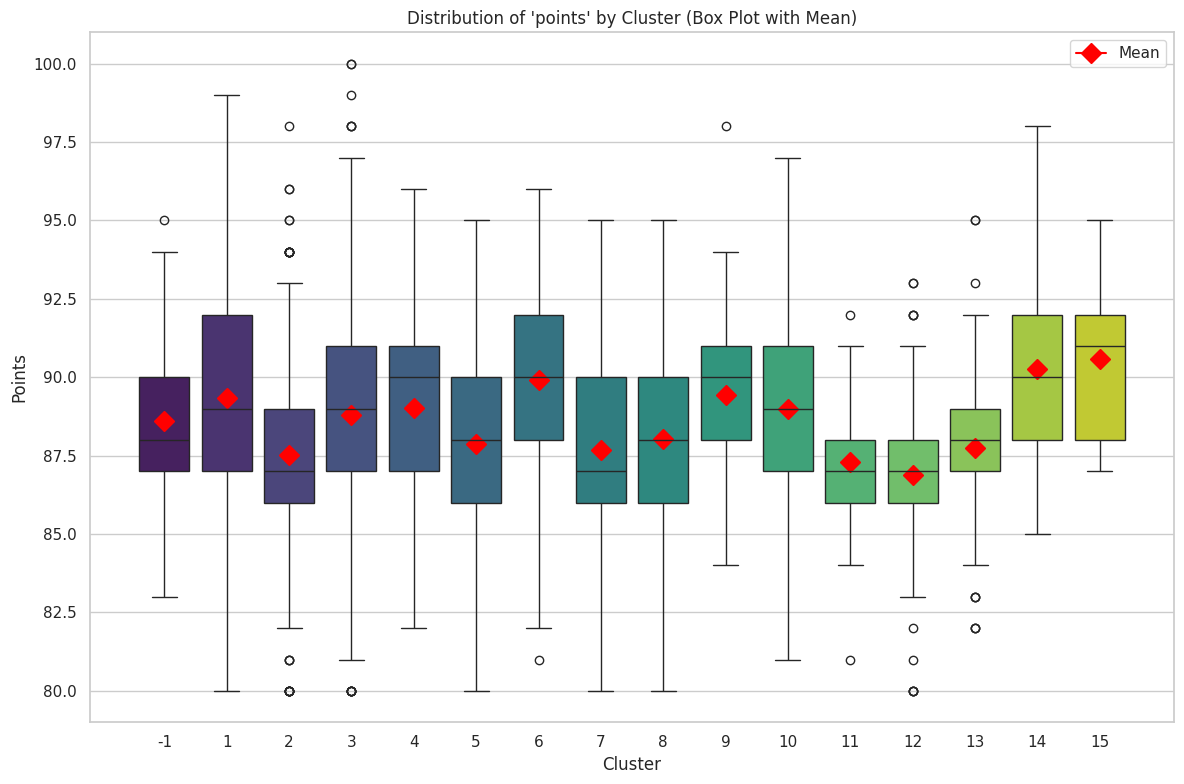


Descriptive Statistics for 'points' by Cluster:
              Mean  Median  Standard Deviation
cluster                                       
-1       88.617347    88.0            2.627567
 1       89.348132    89.0            3.092855
 2       87.511278    87.0            2.537948
 3       88.795630    89.0            2.973796
 4       89.008475    90.0            2.636028
 5       87.883846    88.0            2.990035
 6       89.909091    90.0            2.734854
 7       87.689139    87.0            2.554309
 8       88.032609    88.0            2.860896
 9       89.425926    90.0            2.514272
 10      89.003623    89.0            2.785023
 11      87.311111    87.0            2.086997
 12      86.891089    87.0            2.813898
 13      87.753333    88.0            2.204135
 14      90.274725    90.0            2.343150
 15      90.586957    91.0            2.324518


In [73]:
plot_cluster_numerical_distribution(df_sem_cluster_0, 'points')

/tmp/ipython-input-60-2964964652.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot_ax = sns.boxplot(x='cluster', y=numerical_col, data=df, palette="viridis")


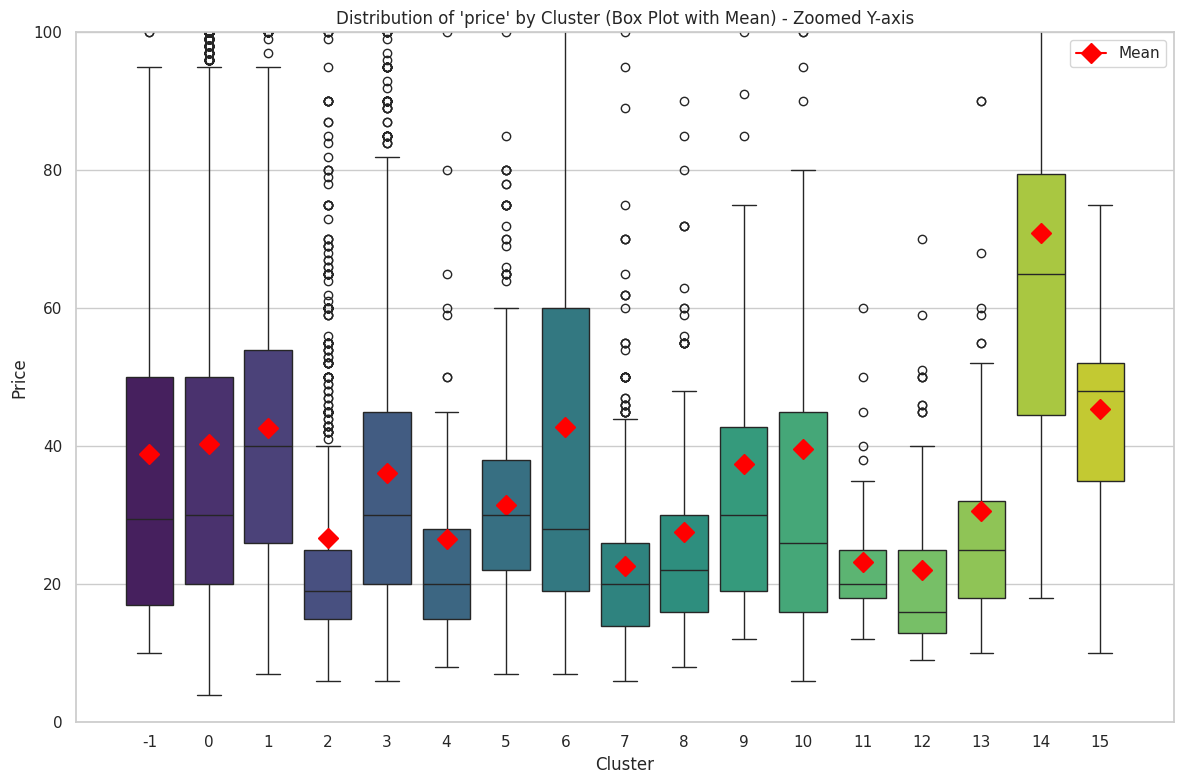


Mean of 'price' by Cluster:
cluster
-1     38.821429
 0     40.352457
 1     42.591966
 2     26.676692
 3     36.172879
 4     26.618644
 5     31.494615
 6     42.849650
 7     22.645443
 8     27.630435
 9     37.388889
 10    39.550725
 11    23.244444
 12    22.118812
 13    30.686667
 14    70.857143
 15    45.413043
Name: price, dtype: float64

Median of 'price' by Cluster:
cluster
-1     29.5
 0     30.0
 1     40.0
 2     19.0
 3     30.0
 4     20.0
 5     30.0
 6     28.0
 7     20.0
 8     22.0
 9     30.0
 10    26.0
 11    20.0
 12    16.0
 13    25.0
 14    65.0
 15    48.0
Name: price, dtype: float64

Standard Deviation of 'price' by Cluster:
cluster
-1     37.430465
 0     36.800766
 1     25.909889
 2     33.440343
 3     31.328903
 4     31.279528
 5     12.847209
 6     35.564448
 7     14.035015
 8     19.604682
 9     26.547729
 10    43.632694
 11    10.050227
 12    16.061312
 13    33.632466
 14    40.582583
 15    15.476974
Name: price, dtype: float64


In [61]:
plot_cluster_numerical_distribution(df, 'price', y_limit=(0, 100))


In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np # Importar numpy para normalização

def plot_top_n_heatmap_per_cluster_normalized_by_row(dataframe, col: str, n: int = 10):
    """
    Gera um mapa de calor mostrando a distribuição percentual das top N entradas
    de uma coluna categórica através dos clusters, normalizado por linha.

    Args:
        col (str): O nome da coluna no DataFrame para analisar (ex: 'designation', 'variety').
        n (int): O número de top entradas a serem incluídas no heatmap.
    """
    # Seleciona as N entradas mais populares da coluna
    # Se n for None, seleciona todas as entradas únicas
    if n is not None:
        top_entries = dataframe[col].value_counts().nlargest(n).index
        title_prefix = f'Top {n} {col.capitalize()}'
        figsize_height = n * 0.5 + 2
        df_top = dataframe[dataframe[col].isin(top_entries)]
    else:
        top_entries = dataframe[col].unique()
        title_prefix = f'Todos os {col.capitalize()}es'
        figsize_height = len(top_entries) * 0.5 + 2
        df_top = dataframe.copy() # Usa o DataFrame completo

    # Cria a tabela de contagem cruzada: linhas = top_entries, colunas = cluster, valores = contagem
    pivot_table = pd.crosstab(df_top[col], df_top['cluster'])

    # Garante que a ordem das linhas no heatmap corresponda à popularidade (se n não for None)
    if n is not None:
         pivot_table = pivot_table.loc[top_entries]

    # --- Normaliza a tabela por linha ---
    # Divide cada valor na linha pela soma dos valores na linha
    pivot_table_normalized = pivot_table.divide(pivot_table.sum(axis=0), axis=1) * 100 # Multiplica por 100 para ter percentual
    # Substitui NaN por 0 em caso de linhas com soma zero (embora improvável com contagens)
    pivot_table_normalized = pivot_table_normalized.fillna(0)
    # --- Fim da normalização ---

    # Cria o mapa de calor a partir dos dados normalizados
    plt.figure(figsize=(15, figsize_height)) # Ajusta o tamanho da figura dinamicamente
    sns.heatmap(
        pivot_table_normalized, # Usa a tabela normalizada
        annot=True,  # Mostrar os números no heatmap (agora percentuais)
        fmt='.1f',   # Formatar os números como floats com 1 casa decimal
        cmap='coolwarm', # Altera a paleta de cores para Azul para Vermelho
        linewidths=.5, # Adiciona linhas entre as células para melhor visualização
        cbar_kws={'label': f'Percentual dentro do {col.capitalize()}'} # Rótulo da barra de cores
    )
    plt.title(f'Distribuição Percentual de {title_prefix} por Cluster (Mapa de Calor - Azul para Vermelho)')
    plt.xlabel('Cluster')
    plt.ylabel(col.capitalize())
    plt.show()


In [81]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def test_categorical_cluster_association(df: pd.DataFrame, category_col: str, n_top_categories: int = 10, alpha: float = 0.05):
    """
    Realiza um teste qui-quadrado de independência para verificar se há uma
    associação significativa entre uma coluna categórica (focando nas top N)
    e a coluna 'cluster'.

    Args:
        df (pd.DataFrame): O DataFrame contendo as colunas category_col e 'cluster'.
        category_col (str): O nome da coluna categórica para testar.
        n_top_categories (int): O número de top categorias a serem incluídas no teste.
                                 Se None, todas as categorias únicas serão usadas.
        alpha (float): O nível de significância para o teste.

    Returns:
        tuple: Uma tupla contendo:
               - chi2 (float): O valor da estatística qui-quadrado.
               - p (float): O valor p do teste.
               - dof (int): Os graus de liberdade.
               - expected (np.ndarray): As frequências esperadas.
               - contingency_table (pd.DataFrame): A tabela de contingência usada.
               - category_col (str): O nome da coluna categórica testada.
    """
    # Seleciona as N categorias mais populares ou todas se n_top_categories é None
    if n_top_categories is not None:
        top_categories = df[category_col].value_counts().nlargest(n_top_categories).index
        df_filtered = df[df[category_col].isin(top_categories)].copy()
        print(f"Realizando teste com as Top {n_top_categories} categorias de '{category_col}'.")
    else:
        df_filtered = df.copy()
        print(f"Realizando teste com todas as categorias únicas de '{category_col}'.")


    # Verifica se há dados suficientes para criar a tabela de contingência
    if len(df_filtered) == 0 or df_filtered[category_col].nunique() < 2 or df_filtered['cluster'].nunique() < 2:
        print(f"Dados insuficientes para realizar o teste Qui-Quadrado para '{category_col}'.")
        return None, None, None, None, None, category_col

    # Cria a tabela de contingência (tabela de contagem cruzada)
    # Garante que o cluster -1 (ruído) seja incluído se estiver presente
    contingency_table = pd.crosstab(df_filtered[category_col], df_filtered['cluster'], dropna=False)

    # Realiza o teste qui-quadrado de independência
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"\nTeste Qui-Quadrado de Independência para '{category_col}' e Clusters:")
    print(f"Estatística Qui-Quadrado: {chi2:.4f}")
    print(f"Valor p: {p:.4f}")
    print(f"Graus de Liberdade: {dof}")

    if p < alpha:
        print(f"\nCom base no valor p ({p:.4f} < {alpha}), rejeitamos a hipótese nula.")
        print(f"Há uma associação estatisticamente significativa entre '{category_col}' e cluster.")
        print(f"Isso sugere que a distribuição de '{category_col}' é significativamente diferente entre os clusters.")
    else:
        print(f"\nCom base no valor p ({p:.4f} >= {alpha}), não podemos rejeitar a hipótese nula.")
        print(f"Não há evidência estatisticamente significativa de que a distribuição de '{category_col}' seja diferente entre os clusters.")

    return chi2, p, dof, expected, contingency_table, category_col

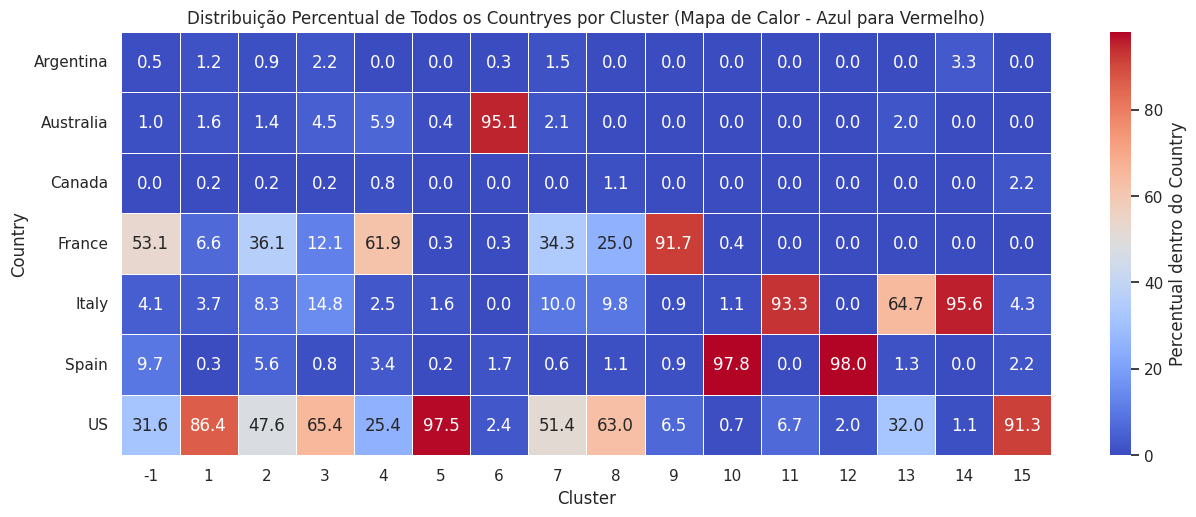

In [76]:
plot_top_n_heatmap_per_cluster_normalized_by_row(dataframe= df_sem_cluster_0,col='country', n=None)

In [82]:
test_categorical_cluster_association(df_sem_cluster_0, "country")

Realizando teste com as Top 10 categorias de 'country'.

Teste Qui-Quadrado de Independência para 'country' e Clusters:
Estatística Qui-Quadrado: 17489.7457
Valor p: 0.0000
Graus de Liberdade: 90

Com base no valor p (0.0000 < 0.05), rejeitamos a hipótese nula.
Há uma associação estatisticamente significativa entre 'country' e cluster.
Isso sugere que a distribuição de 'country' é significativamente diferente entre os clusters.


(np.float64(17489.745740332157),
 np.float64(0.0),
 90,
 array([[2.33800765e+00, 3.38533965e+01, 1.58650519e+01, 3.71218357e+01,
         1.40757603e+00, 1.55071936e+01, 3.41158259e+00, 9.55481697e+00,
         2.19486432e+00, 1.28828993e+00, 3.29229649e+00, 5.36787470e-01,
         1.20478966e+00, 1.78929157e+00, 1.08550355e+00, 5.48716081e-01],
        [9.10216718e+00, 1.31795666e+02, 6.17647059e+01, 1.44520124e+02,
         5.47987616e+00, 6.03715170e+01, 1.32817337e+01, 3.71981424e+01,
         8.54489164e+00, 5.01547988e+00, 1.28173375e+01, 2.08978328e+00,
         4.69040248e+00, 6.96594427e+00, 4.22600619e+00, 2.13622291e+00],
        [3.03405573e-01, 4.39318885e+00, 2.05882353e+00, 4.81733746e+00,
         1.82662539e-01, 2.01238390e+00, 4.42724458e-01, 1.23993808e+00,
         2.84829721e-01, 1.67182663e-01, 4.27244582e-01, 6.96594427e-02,
         1.56346749e-01, 2.32198142e-01, 1.40866873e-01, 7.12074303e-02],
        [2.93767984e+01, 4.25364050e+02, 1.99342561e+02, 4.664316

In [ ]:
plot_top_n_heatmap_per_cluster_normalized_by_row(dataframe= df_sem_cluster_0,col='designation', n=None)

In [45]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def test_designation_cluster_association(df, n_top_designations: int = 10, alpha: float = 0.05):
    """
    Realiza um teste qui-quadrado de independência para verificar se há uma
    associação significativa entre 'designation' (focando nas top N) e 'cluster'.

    Args:
        df (pd.DataFrame): O DataFrame contendo as colunas 'designation' e 'cluster'.
        n_top_designations (int): O número de top designações a serem incluídas no teste.
        alpha (float): O nível de significância para o teste.

    Returns:
        tuple: Uma tupla contendo:
               - chi2 (float): O valor da estatística qui-quadrado.
               - p (float): O valor p do teste.
               - dof (int): Os graus de liberdade.
               - expected (np.ndarray): As frequências esperadas.
               - contingency_table (pd.DataFrame): A tabela de contingência usada.
    """
    # Seleciona as N designações mais populares
    top_designations = df['designation'].value_counts().nlargest(n_top_designations).index

    # Filtra o DataFrame para incluir apenas as linhas com essas top designações
    df_filtered = df[df['designation'].isin(top_designations)]

    # Cria a tabela de contingência (tabela de contagem cruzada)
    contingency_table = pd.crosstab(df_filtered['designation'], df_filtered['cluster'])

    # Realiza o teste qui-quadrado de independência
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Teste Qui-Quadrado de Independência para Top {n_top_designations} Designações e Clusters:")
    print(f"Estatística Qui-Quadrado: {chi2:.4f}")
    print(f"Valor p: {p:.4f}")
    print(f"Graus de Liberdade: {dof}")

    if p < alpha:
        print(f"\nCom base no valor p ({p:.4f} < {alpha}), rejeitamos a hipótese nula.")
        print("Há uma associação estatisticamente significativa entre designação (top N) e cluster.")
        print("Isso sugere que a distribuição das designações é significativamente diferente entre os clusters.")
    else:
        print(f"\nCom base no valor p ({p:.4f} >= {alpha}), não podemos rejeitar a hipótese nula.")
        print("Não há evidência estatisticamente significativa de que a distribuição das designações (top N) seja diferente entre os clusters.")

    return chi2, p, dof, expected, contingency_table

# Execute a função para realizar o teste com as top 10 designações
chi2_stat, p_value, df_dof, expected_freq, cont_table = test_designation_cluster_association(df, n_top_designations=10, alpha=0.05)

# Opcionalmente, você pode inspecionar a tabela de contingência e as frequências esperadas
# print("\nTabela de Contingência Observada (Top 10 Designações):")
# print(cont_table)
# print("\nFrequências Esperadas (Top 10 Designações):")
# print(pd.DataFrame(expected_freq, index=cont_table.index, columns=cont_table.columns))

Teste Qui-Quadrado de Independência para Top 10 Designações e Clusters:
Estatística Qui-Quadrado: 1638.6929
Valor p: 0.0000
Graus de Liberdade: 135

Com base no valor p (0.0000 < 0.05), rejeitamos a hipótese nula.
Há uma associação estatisticamente significativa entre designação (top N) e cluster.
Isso sugere que a distribuição das designações é significativamente diferente entre os clusters.


In [ ]:
plot_top_n_heatmap_per_cluster_normalized_by_row(dataframe= df_sem_cluster_0,col='variety', n=None)

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def test_variety_cluster_association(df, n_top_varieties: int = 10, alpha: float = 0.05):
    """
    Realiza um teste qui-quadrado de independência para verificar se há uma
    associação significativa entre 'variety' (focando nas top N) e 'cluster'.

    Args:
        df (pd.DataFrame): O DataFrame contendo as colunas 'variety' e 'cluster'.
        n_top_varieties (int): O número de top variedades a serem incluídas no teste.
        alpha (float): O nível de significância para o teste.

    Returns:
        tuple: Uma tupla contendo:
               - chi2 (float): O valor da estatística qui-quadrado.
               - p (float): O valor p do teste.
               - dof (int): Os graus de liberdade.
               - expected (np.ndarray): As frequências esperadas.
               - contingency_table (pd.DataFrame): A tabela de contingência usada.
    """
    # Seleciona as N variedades mais populares
    top_varieties = df['variety'].value_counts().nlargest(n_top_varieties).index

    # Filtra o DataFrame para incluir apenas as linhas com essas top variedades
    df_filtered = df[df['variety'].isin(top_varieties)]

    # Cria a tabela de contingência (tabela de contagem cruzada)
    contingency_table = pd.crosstab(df_filtered['variety'], df_filtered['cluster'])

    # Realiza o teste qui-quadrado de independência
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Teste Qui-Quadrado de Independência para Top {n_top_varieties} Variedades e Clusters:")
    print(f"Estatística Qui-Quadrado: {chi2:.4f}")
    print(f"Valor p: {p:.4f}")
    print(f"Graus de Liberdade: {dof}")

    if p < alpha:
        print(f"\nCom base no valor p ({p:.4f} < {alpha}), rejeitamos a hipótese nula.")
        print("Há uma associação estatisticamente significativa entre variedade (top N) e cluster.")
        print("Isso sugere que a distribuição das variedades é significativamente diferente entre os clusters.")
    else:
        print(f"\nCom base no valor p ({p:.4f} >= {alpha}), não podemos rejeitar a hipótese nula.")
        print("Não há evidência estatisticamente significativa de que a distribuição das variedades (top N) seja diferente entre os clusters.")

    return chi2, p, dof, expected, contingency_table

# Execute a função para realizar o teste com as top 10 variedades
chi2_stat, p_value, df_dof, expected_freq, cont_table = test_variety_cluster_association(df, n_top_varieties=10, alpha=0.05)

# Opcionalmente, você pode inspecionar a tabela de contingência e as frequências esperadas
# print("\nTabela de Contingência Observada (Top 10 Variedades):")
# print(cont_table)
# print("\nFrequências Esperadas (Top 10 Variedades):")
# print(pd.DataFrame(expected_freq, index=cont_table.index, columns=cont_table.columns))

Teste Qui-Quadrado de Independência para Top 10 Variedades e Clusters:
Estatística Qui-Quadrado: 54387.0879
Valor p: 0.0000
Graus de Liberdade: 63

Com base no valor p (0.0000 < 0.05), rejeitamos a hipótese nula.
Há uma associação estatisticamente significativa entre variedade (top N) e cluster.
Isso sugere que a distribuição das variedades é significativamente diferente entre os clusters.


In [ ]:
df.colmuns

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def test_taster_cluster_association(df, n_top_tasters: int = 10, alpha: float = 0.05):
    """
    Realiza um teste qui-quadrado de independência para verificar se há uma
    associação significativa entre 'taster_twitter_handle' (focando nos top N) e 'cluster'.

    Args:
        df (pd.DataFrame): O DataFrame contendo as colunas 'taster_twitter_handle' e 'cluster'.
        n_top_tasters (int): O número de top identificadores de provadores a serem incluídos no teste.
        alpha (float): O nível de significância para o teste.

    Returns:
        tuple: Uma tupla contendo:
               - chi2 (float): O valor da estatística qui-quadrado.
               - p (float): O valor p do teste.
               - dof (int): Os graus de liberdade.
               - expected (np.ndarray): As frequências esperadas.
               - contingency_table (pd.DataFrame): A tabela de contingência usada.
    """
    # Seleciona os N identificadores de provadores mais populares
    top_tasters = df['taster_twitter_handle'].value_counts().nlargest(n_top_tasters).index

    # Filtra o DataFrame para incluir apenas as linhas com esses top provadores
    df_filtered = df[df['taster_twitter_handle'].isin(top_tasters)]

    # Cria a tabela de contingência (tabela de contagem cruzada)
    contingency_table = pd.crosstab(df_filtered['taster_twitter_handle'], df_filtered['cluster'])

    # Realiza o teste qui-quadrado de independência
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Teste Qui-Quadrado de Independência para Top {n_top_tasters} Taster Twitter Handles e Clusters:")
    print(f"Estatística Qui-Quadrado: {chi2:.4f}")
    print(f"Valor p: {p:.4f}")
    print(f"Graus de Liberdade: {dof}")

    if p < alpha:
        print(f"\nCom base no valor p ({p:.4f} < {alpha}), rejeitamos a hipótese nula.")
        print("Há uma associação estatisticamente significativa entre taster_twitter_handle (top N) e cluster.")
        print("Isso sugere que a distribuição dos taster_twitter_handle é significativamente diferente entre os clusters.")
    else:
        print(f"\nCom base no valor p ({p:.4f} >= {alpha}), não podemos rejeitar a hipótese nula.")
        print("Não há evidência estatisticamente significativa de que a distribuição dos taster_twitter_handle (top N) seja diferente entre os clusters.")

    return chi2, p, dof, expected, contingency_table

# Execute a função para realizar o teste com os top 10 taster_twitter_handle
chi2_stat, p_value, df_dof, expected_freq, cont_table = test_taster_cluster_association(df, n_top_tasters=10, alpha=0.05)

# Opcionalmente, você pode inspecionar a tabela de contingência e as frequências esperadas
# print("\nTabela de Contingência Observada (Top 10 Taster Twitter Handles):")
# print(cont_table)
# print("\nFrequências Esperadas (Top 10 Taster Twitter Handles):")
# print(pd.DataFrame(expected_freq, index=cont_table.index, columns=cont_table.columns))

Teste Qui-Quadrado de Independência para Top 10 Taster Twitter Handles e Clusters:
Estatística Qui-Quadrado: 41886.2489
Valor p: 0.0000
Graus de Liberdade: 63

Com base no valor p (0.0000 < 0.05), rejeitamos a hipótese nula.
Há uma associação estatisticamente significativa entre taster_twitter_handle (top N) e cluster.
Isso sugere que a distribuição dos taster_twitter_handle é significativamente diferente entre os clusters.


In [ ]:
plot_top_n_heatmap_per_cluster_normalized_by_row(dataframe= df_sem_cluster_0,col='region_1', n=None)

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

def test_region_cluster_association(df, n_top_regions: int = 10, alpha: float = 0.05):
    """
    Realiza um teste qui-quadrado de independência para verificar se há uma
    associação significativa entre 'region_1' (focando nas top N) e 'cluster'.

    Args:
        df (pd.DataFrame): O DataFrame contendo as colunas 'region_1' e 'cluster'.
        n_top_regions (int): O número de top regiões a serem incluídas no teste.
        alpha (float): O nível de significância para o teste.

    Returns:
        tuple: Uma tupla contendo:
               - chi2 (float): O valor da estatística qui-quadrado.
               - p (float): O valor p do teste.
               - dof (int): Os graus de liberdade.
               - expected (np.ndarray): As frequências esperadas.
               - contingency_table (pd.DataFrame): A tabela de contingência usada.
    """
    # Seleciona as N regiões mais populares
    top_regions = df['region_1'].value_counts().nlargest(n_top_regions).index

    # Filtra o DataFrame para incluir apenas as linhas com essas top regiões
    df_filtered = df[df['region_1'].isin(top_regions)]

    # Cria a tabela de contingência (tabela de contagem cruzada)
    contingency_table = pd.crosstab(df_filtered['region_1'], df_filtered['cluster'])

    # Realiza o teste qui-quadrado de independência
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    print(f"Teste Qui-Quadrado de Independência para Top {n_top_regions} Regiões e Clusters:")
    print(f"Estatística Qui-Quadrado: {chi2:.4f}")
    print(f"Valor p: {p:.4f}")
    print(f"Graus de Liberdade: {dof}")

    if p < alpha:
        print(f"\nCom base no valor p ({p:.4f} < {alpha}), rejeitamos a hipótese nula.")
        print("Há uma associação estatisticamente significativa entre região (top N) e cluster.")
        print("Isso sugere que a distribuição das regiões é significativamente diferente entre os clusters.")
    else:
        print(f"\nCom base no valor p ({p:.4f} >= {alpha}), não podemos rejeitar a hipótese nula.")
        print("Não há evidência estatisticamente significativa de que a distribuição das regiões (top N) seja diferente entre os clusters.")

    return chi2, p, dof, expected, contingency_table

# Execute a função para realizar o teste com as top 10 regiões
chi2_stat, p_value, df_dof, expected_freq, cont_table = test_region_cluster_association(df, n_top_regions=10, alpha=0.05)

# Opcionalmente, você pode inspecionar a tabela de contingência e as frequências esperadas
# print("\nTabela de Contingência Observada (Top 10 Regiões):")
# print(cont_table)
# print("\nFrequências Esperadas (Top 10 Regiões):")
# print(pd.DataFrame(expected_freq, index=cont_table.index, columns=cont_table.columns))

Teste Qui-Quadrado de Independência para Top 10 Regiões e Clusters:
Estatística Qui-Quadrado: 16960.0846
Valor p: 0.0000
Graus de Liberdade: 63

Com base no valor p (0.0000 < 0.05), rejeitamos a hipótese nula.
Há uma associação estatisticamente significativa entre região (top N) e cluster.
Isso sugere que a distribuição das regiões é significativamente diferente entre os clusters.


V de Cramer para 'country': 0.5179
V de Cramer para 'designation' (Top 10): 0.3801
V de Cramer para 'variety' (Top 10): 0.6824
V de Cramer para 'taster_twitter_handle' (Top 10): 0.4150


/tmp/ipython-input-80-741071251.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Cramers_V', y='Characteristic', data=df_v_scores, palette='viridis')


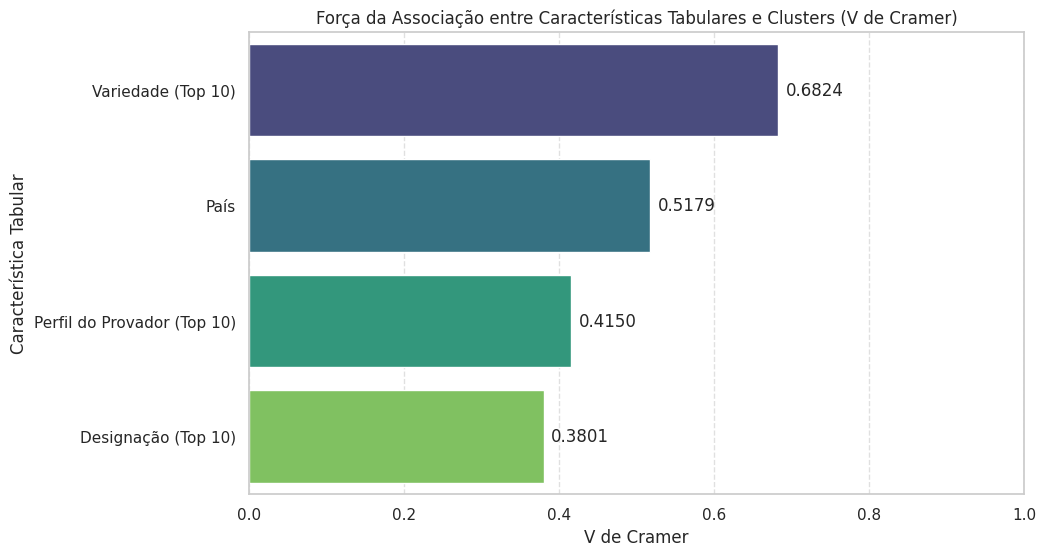

In [80]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def cramers_v(contingency_table):
    """
    Calcula o V de Cramer, uma medida de associação para tabelas de contingência.
    (A função permanece a mesma)

    Args:
        contingency_table (pd.DataFrame): A tabela de contingência (pd.crosstab).

    Returns:
        float: O valor do V de Cramer.
    """
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    min_dim = min(contingency_table.shape) - 1
    # Prevenir divisão por zero se n ou min_dim for zero
    if n == 0 or min_dim == 0:
        return 0.0
    v = np.sqrt(chi2 / (n * min_dim))
    return v

# Assumindo que 'df' é o seu DataFrame já limpo e com a coluna 'cluster'

# --- Calcular V de Cramer para cada característica ---

# V de Cramer para Country (usando todos os países ou top N se preferir consistência com o teste anterior)
# Usaremos todos os países para ter uma visão mais completa, a menos que a memória seja um problema
# top_n_country = 10 # Defina para usar top N
# if top_n_country is not None:
#     top_countries = df['country'].value_counts().nlargest(top_n_country).index
#     df_country = df[df['country'].isin(top_countries)]
# else:
def apply_V_crame(df):
  df_country = df.copy()
  contingency_country = pd.crosstab(df_country['country'], df_country['cluster'])
  v_country = cramers_v(contingency_country)
  print(f"V de Cramer para 'country': {v_country:.4f}")

  # V de Cramer para Designation (usando top 10 conforme seu teste)
  top_n_designation = 10
  top_designations = df['designation'].value_counts().nlargest(top_n_designation).index
  df_designation = df[df['designation'].isin(top_designations)]
  contingency_designation = pd.crosstab(df_designation['designation'], df_designation['cluster'])
  v_designation = cramers_v(contingency_designation)
  print(f"V de Cramer para 'designation' (Top {top_n_designation}): {v_designation:.4f}")

  # V de Cramer para Variety (usando top 10 conforme seu teste)
  top_n_variety = 10
  top_varieties = df['variety'].value_counts().nlargest(top_n_variety).index
  df_variety = df[df['variety'].isin(top_varieties)]
  contingency_variety = pd.crosstab(df_variety['variety'], df_variety['cluster'])
  v_variety = cramers_v(contingency_variety)
  print(f"V de Cramer para 'variety' (Top {top_n_variety}): {v_variety:.4f}")

  # V de Cramer para Taster Twitter Handle (usando top 10 conforme seu teste)
  top_n_taster = 10
  top_tasters = df['taster_twitter_handle'].value_counts().nlargest(top_n_taster).index
  df_taster = df[df['taster_twitter_handle'].isin(top_tasters)]
  contingency_taster = pd.crosstab(df_taster['taster_twitter_handle'], df_taster['cluster'])
  v_taster = cramers_v(contingency_taster)
  print(f"V de Cramer para 'taster_twitter_handle' (Top {top_n_taster}): {v_taster:.4f}")

  # --- Visualizar os valores de V de Cramer ---

  v_scores_data = {
      'Characteristic': ['País', f'Designação (Top {top_n_designation})', f'Variedade (Top {top_n_variety})', f'Perfil do Provador (Top {top_n_taster})'],
      'Cramers_V': [v_country, v_designation, v_variety, v_taster]
  }

  df_v_scores = pd.DataFrame(v_scores_data)

  # Ordena para melhor visualização (do maior para o menor V de Cramer)
  df_v_scores = df_v_scores.sort_values('Cramers_V', ascending=False)

  plt.figure(figsize=(10, 6))
  # Cria o gráfico de barras usando os scores de V de Cramer
  ax = sns.barplot(x='Cramers_V', y='Characteristic', data=df_v_scores, palette='viridis')
  plt.xlabel("V de Cramer") # Rótulo do eixo X
  plt.ylabel("Característica Tabular") # Rótulo do eixo Y
  plt.title("Força da Associação entre Características Tabulares e Clusters (V de Cramer)") # Título do gráfico
  plt.xlim(0, 1) # Define o limite do eixo X de 0 a 1 (intervalo de V de Cramer)
  plt.grid(axis='x', linestyle='--', alpha=0.6) # Adiciona linhas de grade no eixo X

  # Adiciona os valores exatos de V de Cramer nas barras
  # Iteramos sobre os patches (barras) para obter as posições Y
  for p in ax.patches:
      # p.get_width() retorna a largura da barra (o valor de Cramers_V)
      # p.get_y() + p.get_height() / 2 retorna a posição Y central da barra
      ax.text(p.get_width() + 0.01, # Posiciona o texto ligeiramente à direita da barra
              p.get_y() + p.get_height() / 2, # Centraliza o texto verticalmente na barra
              f"{p.get_width():.4f}", # Formata o texto com o valor de Cramers_V
              va='center') # Alinha verticalmente o texto ao centro

  plt.show() # Exibe o gráfico

df_sem_outliners = df_sem_cluster_0[df_sem_cluster_0["cluster"] != -1]
apply_V_crame(df_sem_outliners)

In [ ]:
from collections import Counter

def get_top_n_words(corpus, n=None):
    words = [word for sentence in corpus for word in sentence.split()]
    word_counts = Counter(words)
    return word_counts.most_common(n)

# Exemplo: Top 20 palavras para cada cluster
for cluster_id in sorted(df['cluster'].unique()):
    print(f"\nTop palavras para o Cluster {cluster_id}:")
    cluster_descriptions = df[df['cluster'] == cluster_id]['description']
    top_words = get_top_n_words(cluster_descriptions, n=20)
    print(top_words)


Top palavras para o Cluster 0:
[('wine', 12434), ('drink', 4401), ('fruit', 4327), ('flavors', 3933), ('acidity', 3653), ('tannins', 3066), ('ripe', 3059), ('fruits', 2444), ('rich', 2263), ('oak', 2065), ('red', 1665), ('black', 1643), ('age', 1633), ('texture', 1580), ('years', 1545), ('cherry', 1523), ('well', 1510), ('aging', 1314), ('crisp', 1290), ('character', 1283)]

Top palavras para o Cluster 1:
[('wine', 9279), ('flavors', 5472), ('fruit', 4128), ('black', 3899), ('cherry', 3883), ('palate', 3833), ('aromas', 3785), ('tannins', 2825), ('finish', 2820), ('nose', 2456), ('acidity', 2107), ('red', 1992), ('spice', 1834), ('ripe', 1827), ('blackberry', 1675), ('notes', 1609), ('plum', 1609), ('dark', 1584), ('pepper', 1493), ('drink', 1373)]

Top palavras para o Cluster 2:
[('aromas', 7297), ('flavors', 6965), ('palate', 5946), ('finish', 5276), ('tannins', 4590), ('cherry', 4446), ('berry', 4000), ('fruit', 3465), ('black', 3394), ('plum', 3277), ('drink', 3165), ('spice', 271

In [ ]:
print(len(embeddings))

NameError: name 'embeddings' is not defined

# Fazendo uma segunda analise para o cluster 1